In [1]:
import bw2data as bd
import bw2regional as bwr
import bw2calc as bc
import bw2io as bi
import bw2analyzer as ba
from bw_temporalis import TemporalDistribution as TD, TemporalisLCA, supplement_dataframe
from bw_temporalis.lcia import characterize_methane, characterize_co2
import numpy as np
from pathlib import Path

In [16]:
RESET = True

if RESET:
    bi.restore_project_directory("/srv/data/projects/ei.tar.gz", True)

Restoring project backup archive - this could take a few minutes...


In [2]:
bd.projects.set_current("ei")

In [18]:
bd.databases

Databases dictionary with 2 object(s):
	biosphere3
	ecoinvent-3.9.1-cutoff

In [19]:
water = bd.get_node(id=3615)
water

'Water' (cubic meter, None, ('water', 'surface water'))

In [20]:
co2 = bd.get_node(id=1171)
co2

'Carbon dioxide, fossil' (kilogram, None, ('air',))

In [21]:
ch4 = bd.get_node(id=1652)
ch4

'Methane, fossil' (kilogram, None, ('air',))

In [5]:
food = bd.Database("food")
food.register()

In [23]:
lemon = food.new_node(
    code="lemon",
    name="lemon",
    location=('regions', 'Granada')
)
lemon.save()
lemon.new_edge(
    input=water,
    amount=5,
    type="biosphere",
    temporal_distribution=TD(
        np.array([-3, -2, -1, 0, 1], dtype="timedelta64[Y]"),
        np.ones(5)
    )
).save()
lemon.new_edge(
    input=co2,
    amount=0.2,
    type="biosphere",
    temporal_distribution=TD(
        np.array([-1, 0, 1], dtype="timedelta64[M]"),
        np.ones(3) * 2/3
    )
).save()

In [24]:
mushroom = food.new_node(
    code="mushroom",
    name="mushroom",
    location=('countries', 'Portugal')
)
mushroom.save()
mushroom.new_edge(
    input=water,
    amount=0.5,
    type="biosphere",
    temporal_distribution=TD(
        np.array([-3, -2, -1], dtype="timedelta64[M]"),
        np.ones(3) * 0.5
    )    
).save()
mushroom.new_edge(
    input=ch4,
    amount=0.05,
    type="biosphere",
    temporal_distribution=TD(
        np.array([-3, -2, -1, 0], dtype="timedelta64[M]"),
        np.ones(4) * 0.0125
    )    
).save()

In [25]:
cheese = food.new_node(
    code="cheese",
    name="cheese",
    location=('countries', 'Spain')
)
cheese.save()
cheese.new_edge(
    input=water,
    amount=25,
    type="biosphere",
    temporal_distribution=TD(
        np.linspace(-90, -10, 10).astype("timedelta64[D]"),
        np.ones(10) * 10/25
    )    
).save()

In [26]:
rice = food.new_node(
    code="rice",
    name="rice",
    location=('regions', 'Valencia')
)
rice.save()
rice.new_edge(
    input=water,
    amount=10,
    type="biosphere",
).save()

In [27]:
meal = food.new_node(
    code="meal",
    name="meal",
    location=('cities', '14')
)
meal.save()
meal.new_edge(
    input=water,
    amount=0.5,
    type="biosphere",
).save()
meal.new_edge(
    input=lemon,
    amount=0.25,
    type="technosphere",
).save()
meal.new_edge(
    input=rice,
    amount=1,
    type="technosphere",
).save()
meal.new_edge(
    input=mushroom,
    amount=0.5,
    type="technosphere",
).save()
meal.new_edge(
    input=cheese,
    amount=0.1,
    type="technosphere",
).save()

In [3]:
meal = bd.get_node(name="meal")

In [6]:
food.set_geocollections()

In [7]:
ipcc = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')

In [8]:
ei = bd.Database("ecoinvent-3.9.1-cutoff")

In [43]:
rice_ei = bd.get_node(name='market for rice, basmati')
rice_ei

'market for rice, basmati' (kilogram, GLO, None)

In [36]:
cheese_ei = bd.get_node(id=17999)
cheese_ei

'cheese production, soft, from cow milk' (kilogram, GLO, None)

In [37]:
cheese.new_edge(input=cheese_ei, amount=1, type="technosphere").save()

In [44]:
rice.new_edge(input=rice_ei, amount=1, type="technosphere").save()

In [58]:
ba.print_recursive_calculation(meal, ipcc, max_level=7)

Fraction of score | Absolute score | Amount | Activity
0001 | 5.462 |     1 | 'meal' (None, ('cities', '14'), None)
  0.626 |  3.42 |     1 | 'rice' (None, ('regions', 'Valencia'), None)
    0.626 |  3.42 |     1 | 'market for rice, basmati' (kilogram, GLO, None)
      0.448 | 2.445 | 0.7005 | 'rice production, basmati' (kilogram, IN, None)
        0.142 | 0.7781 | 6.289 | 'market for irrigation' (cubic meter, IN, None)
          0.136 | 0.7408 |  6.18 | 'irrigation, surface' (cubic meter, IN, None)
            0.022 | 0.1199 | 1.147 | 'water pump operation, diesel' (megajoule, IN, None)
            0.114 | 0.6209 | 1.474 | 'water pump operation, electric' (megajoule, IN, None)
              0.111 | 0.6035 | 0.4095 | 'market group for electricity, low voltage' (kilowatt hour, IN, None)
        0.0137 | 0.07475 | 0.04336 | 'market for urea' (kilogram, RoW, None)
          0.0133 | 0.07273 | 0.04336 | 'urea production' (kilogram, RoW, None)
            0.0119 | 0.06496 | 0.02018 | 'marke

In [54]:
rpb = bd.get_node(name='rice production, basmati', location='IN')

In [56]:
for ds in ei:
    if ds['name'] == 'rice production, basmati':
        for exc in ds.technosphere():
            if exc.input['name'] == 'market for irrigation':
                exc['temporal_distribution'] = TD(
                    np.linspace(-90, 0, 50).astype("timedelta64[D]"),
                    exc['amount'] / 50 * np.ones(50)
                )
                exc.save()

In [57]:
for ds in ei:
    if ds['name'] == 'market for irrigation':
        for exc in ds.technosphere():
            if exc.input['name'] == 'irrigation, surface':
                exc['temporal_distribution'] = TD(
                    np.linspace(-10, 10, 5).astype("timedelta64[D]"),
                    exc['amount'] / 5 * np.ones(5)
                )
                exc.save()

In [62]:
for ds in ei:
    if ds['name'] == 'rice production, basmati':
        for exc in ds.biosphere():
            if exc['name'] == 'Carbon dioxide, in air':
                exc['temporal_distribution'] = TD(
                    np.linspace(-120, 30, 20).astype("timedelta64[D]"),
                    exc['amount'] / 20 * np.ones(20)
                )
                exc.save()   
            elif exc['name'] == 'Carbon dioxide, fossil':
                exc['temporal_distribution'] = TD(
                    np.linspace(20, 0, 4).astype("timedelta64[D]"),
                    exc['amount'] / 4 * np.ones(4)
                )
                exc.save()   

In [9]:
lca = bc.LCA({meal: 1}, ipcc)
lca.lci()
lca.lcia()

In [10]:
tlca = TemporalisLCA(lca)

Starting graph traversal
Calculation count: 32


In [11]:
tl = tlca.build_timeline()

In [12]:
tl.build_dataframe()

In [13]:
supplement_dataframe(tl.df, "food")

,date,amount,flow,activity,location,name,location_activity,name_activity
0,2023-01-17,1.285823e-08,4688,6279,NaN,NaN,NaN,NaN
1,2023-01-17,3.389682e-04,1171,6279,NaN,NaN,NaN,NaN
2,2023-01-19,1.285823e-08,4688,6279,NaN,NaN,NaN,NaN
3,2023-01-19,3.389682e-04,1171,6279,NaN,NaN,NaN,NaN
4,2023-01-21,1.285823e-08,4688,6279,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
222,2023-05-07,3.389682e-04,1171,6279,NaN,NaN,NaN,NaN
223,2023-05-07,1.285823e-08,4688,6279,NaN,NaN,NaN,NaN
224,2023-05-10,7.943952e-03,1168,4780,NaN,NaN,NaN,NaN
225,2023-05-17,7.943952e-03,1168,4780,NaN,NaN,NaN,NaN


In [14]:
supplement_dataframe(tl.df, "ecoinvent-3.9.1-cutoff")

,date,amount,flow,activity,location,name,unit,location_activity,name_activity,unit_activity
0,2023-01-17,1.285823e-08,4688,6279,NaN,NaN,NaN,IN,"water pump operation, diesel",megajoule
1,2023-01-17,3.389682e-04,1171,6279,NaN,NaN,NaN,IN,"water pump operation, diesel",megajoule
2,2023-01-19,1.285823e-08,4688,6279,NaN,NaN,NaN,IN,"water pump operation, diesel",megajoule
3,2023-01-19,3.389682e-04,1171,6279,NaN,NaN,NaN,IN,"water pump operation, diesel",megajoule
4,2023-01-21,1.285823e-08,4688,6279,NaN,NaN,NaN,IN,"water pump operation, diesel",megajoule
...,...,...,...,...,...,...,...,...,...,...
222,2023-05-07,3.389682e-04,1171,6279,NaN,NaN,NaN,IN,"water pump operation, diesel",megajoule
223,2023-05-07,1.285823e-08,4688,6279,NaN,NaN,NaN,IN,"water pump operation, diesel",megajoule
224,2023-05-10,7.943952e-03,1168,4780,NaN,NaN,NaN,IN,"rice production, basmati",kilogram
225,2023-05-17,7.943952e-03,1168,4780,NaN,NaN,NaN,IN,"rice production, basmati",kilogram


<Axes: xlabel='date', ylabel='amount'>

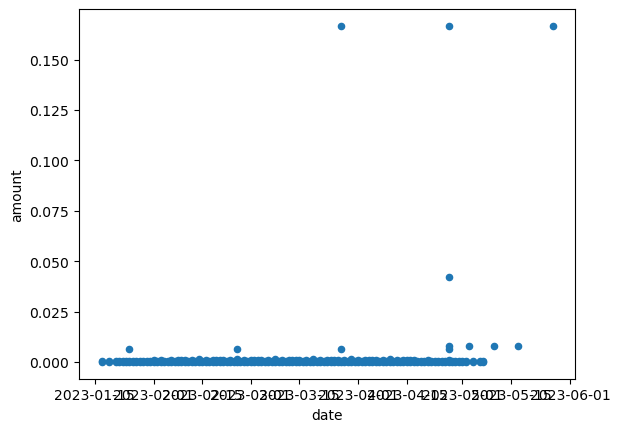

In [15]:
tl.df.plot(x="date", y="amount", kind="scatter")

In [16]:
{x['name'] for x in bd.Database("biosphere3").search("carbon dioxide")}

{'Carbon dioxide, fossil',
 'Carbon dioxide, from soil or biomass stock',
 'Carbon dioxide, in air',
 'Carbon dioxide, non-fossil',
 'Carbon dioxide, non-fossil, resource correction',
 'Carbon dioxide, to soil or biomass stock'}

In [17]:
carbon_dioxides = {x.id for x in bd.Database("biosphere3") if x['name'] in ('Carbon dioxide, fossil', 'Carbon dioxide, from soil or biomass stock')}

In [18]:
characterized_df_co2 = tl.characterize_dataframe(
    characterization_function=characterize_co2, 
    flow=carbon_dioxides,
)

<Axes: xlabel='date'>

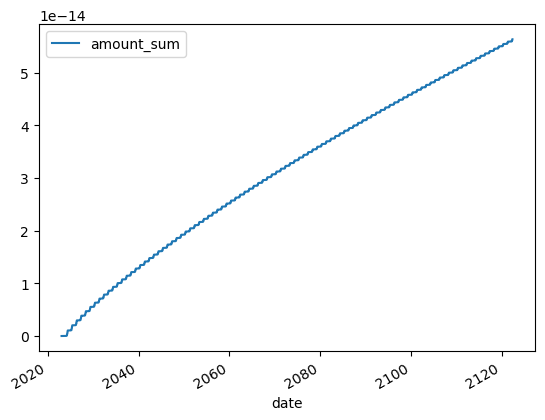

In [19]:
characterized_df_co2.plot(x="date", y="amount_sum")